In [ ]:
## code and notebook by @vijaykrishnavanshi
# https://github.com/vijaykrishnavanshi/unet-pytorch
# data from https://www.kaggle.com/kmader/finding-lungs-in-ct-data

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import csv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode

In [6]:
# Prepare the Dataset
IMAGE_DIR = "../2d_images/"
MASK_DIR = "../2d_masks/"
with open('../Lung_CT_Dataset.csv', 'w') as csv_file:
    print (csv_file)
    writer = csv.writer(csv_file)
    writer.writerow(["filename", "mask"])
    for p in os.listdir(IMAGE_DIR):
        image_path = os.path.join(IMAGE_DIR, p)
        mask_path = os.path.join(MASK_DIR, p)
        writer.writerow([image_path, mask_path])


<_io.TextIOWrapper name='../Lung_CT_Dataset.csv' mode='w' encoding='UTF-8'>


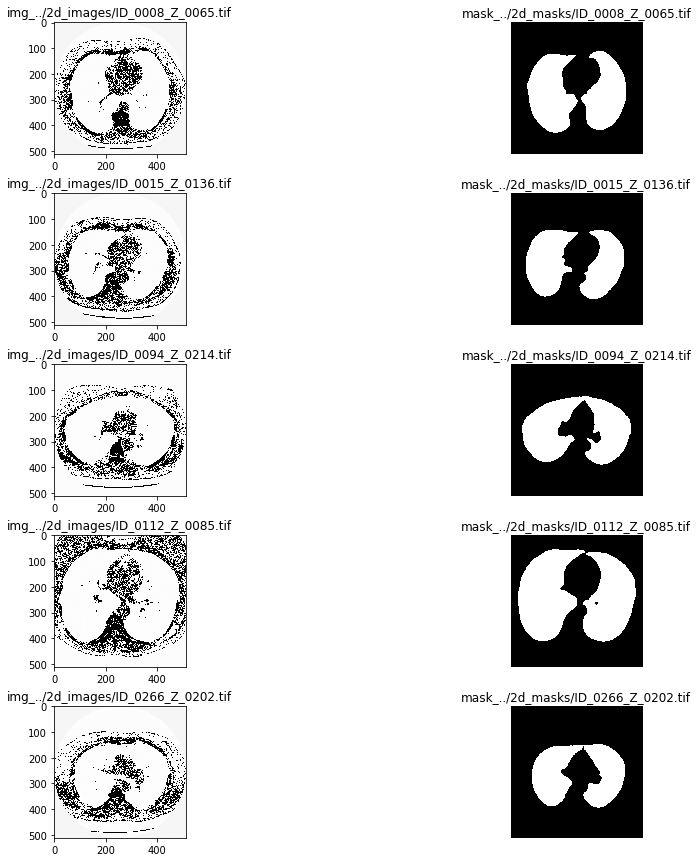

In [31]:
import glob
import cv2
img_list = glob.glob(IMAGE_DIR+'*.tif')
mask_list = glob.glob(MASK_DIR+'*.tif')

plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
for i in range(5):
    img = cv2.imread(img_list[i])
    plt.subplot(5, 2, i*2+1).set_title('img_{}'.format(img_list[i]))
    mask = cv2.imread(mask_list[i])
    plt.imshow(np.asarray(img)) 
    plt.subplot(5, 2, i*2+2).set_title('mask_{}'.format(mask_list[i]))
    plt.imshow(np.asarray(mask))
    plt.axis('off')

In [7]:
data = pd.read_csv("../Lung_CT_Dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
p = int(len(data)*0.7)
train, validation = data[:p], data[p:]
train.to_csv("../Lung_CT_Train.csv", index=False)
validation.to_csv("../Lung_CT_Validation.csv", index=False)

In [8]:
from dataset import LungCTDataset
lung_ct_train_dataset = LungCTDataset(csv_file='../Lung_CT_Train.csv', root_dir='./')
lung_ct_val_dataset = LungCTDataset(csv_file='../Lung_CT_Validation.csv', root_dir='./')
train_dataloader = DataLoader(lung_ct_train_dataset, batch_size=100, shuffle=True, num_workers=4)
val_dataloader = DataLoader(lung_ct_val_dataset, batch_size=100, shuffle=True, num_workers=4)

In [9]:
from model import * 
model_instance = UNet(1, 1)

In [10]:
# model_instance.apply(weights_init)

In [11]:
optimizer = optim.Adam(model_instance.parameters(), lr=0.000001)
criterion = nn.BCELoss()

In [23]:
from tqdm import tqdm
def train(model, epoch):
    print (model)
    model.train()
    correct = 0
    for batch_idx, data in tqdm (enumerate(train_dataloader)):
        data, target = Variable(data["image"]), Variable(data["mask"])
        optimizer.zero_grad()
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         if batch_idx % 1 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_dataloader.dataset),
#                 100. * batch_idx / len(train_dataloader), loss.data[0]))
    

In [24]:
def test(model):
    model.eval()
    test_loss = 0
    for data in val_dataloader:
        data, target = Variable(data["image"], volatile=True), Variable(data["mask"])
        print (data)
        output = model(data.float())
        # print(output.data[0])
        test_loss += criterion(output.float(), target.float()).data[0] # sum up batch loss
    test_loss /= len(val_dataloader.dataset)
    print("Average Loss: ", test_loss)


In [25]:
# 99 % validation accuracy 
for epoch in range(1, 15):
    train(model_instance, epoch)
#     test(model_instance)    

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3

2it [00:00,  5.21it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.15it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.51it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.14it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  4.75it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.28it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.63it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.61it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.40it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.08it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.33it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.51it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.06it/s]

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3


2it [00:00,  5.49it/s]


In [21]:
torch.save(model_instance, './saved_models/mini_unet.pth')